# Analyzing Vegas Implied Probabilities
Here we will use the Vegas break-even implied probability provided by the moneylines to determine whether is it useful in forecasting the probability a team will win. Inspired by FiveThirtyEight, we will use a **model calibration chart.**

In [1]:
import datetime
import pandas as pd
import numpy as np
from itertools import product
from scipy import stats
from odds_utils import odds_parser, odds_parser_prob
import matplotlib.pyplot as plt

filename = r'data/nfl odds 2020-21.csv'
# moneyline is for close data only; would have to write a proper web scraper if you wanted to opening line
hold = pd.read_csv(filename)
hold.head()

,Date,Rot,VH,Team,1st,2nd,3rd,4th,Final,Open,Close,ML,2H
0,910,451,V,Houston,7,0,0,13,20,54,53.5,375,27
1,910,452,H,KansasCity,0,17,7,10,34,9.5,9.5,-450,3.5
2,913,453,V,Miami,0,3,0,8,11,43,41.5,290,20
3,913,454,H,NewEngland,0,7,7,7,21,7,7,-350,3
4,913,455,V,Cleveland,6,0,0,0,6,48.5,47.5,270,22.5


## Analyzing the data

In [2]:
odds = odds_parser(filename)
odds = odds_parser_prob(odds)

In [3]:
odds.iloc[:, -18:]

,OU_Open,OU_Close,OU_2H,Pts_Open,Pts_Close,Pts_2H,Home_Fav,Fav_Team,Dog_Team,ML_Fav,ML_Dog,Prob_Fav,Prob_Dog,Hold,IP_Fav,IP_Dog,Home_Winner,Fav_Winner
0,54.0,53.5,27.0,9.5,9.5,3.5,1.0,KansasCity,Houston,-450.0,375.0,0.818182,0.210526,0.028708,0.795349,0.204651,1,1.0
1,43.0,41.5,20.0,7.0,7.0,3.0,1.0,NewEngland,Miami,-350.0,290.0,0.777778,0.256410,0.034188,0.752066,0.247934,1,1.0
2,48.5,47.5,22.5,8.5,7.0,2.5,1.0,Baltimore,Cleveland,-330.0,270.0,0.767442,0.270270,0.037712,0.739552,0.260448,1,1.0
3,39.5,39.0,19.0,6.0,6.5,3.0,1.0,Buffalo,NYJets,-300.0,250.0,0.750000,0.285714,0.035714,0.724138,0.275862,1,1.0
4,47.0,48.0,24.0,1.5,3.0,1.0,-1.0,LasVegas,Carolina,-150.0,130.0,0.600000,0.434783,0.034783,0.579832,0.420168,-1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,47.5,48.5,23.0,14.0,16.0,6.5,1.0,Seattle,NYJets,-1200.0,750.0,0.923077,0.117647,0.040724,0.886957,0.113043,1,1.0
203,48.5,49.0,25.5,2.5,1.0,3.0,1.0,LAChargers,Atlanta,-120.0,100.0,0.545455,0.500000,0.045455,0.521739,0.478261,1,1.0
204,46.0,42.0,21.0,7.0,7.5,6.0,-1.0,NewOrleans,Philadelphia,-360.0,300.0,0.782609,0.250000,0.032609,0.757895,0.242105,1,0.0
205,43.5,43.5,21.0,3.5,3.0,3.0,1.0,SanFrancisco,Washingtom,-145.0,125.0,0.591837,0.444444,0.036281,0.571116,0.428884,-1,0.0


In [4]:
print('95% interval for the hold: {}'.format(np.round(np.quantile(odds.Hold.dropna().values, [0.025, 0.975]), 3)))

95% interval for the hold: [0.027 0.047]


### Note on the Hold Calculation
Here's a hold calculation on a coin flip where the standard conversation is to offer 50/50 at -110. Assuming 1 person takes each side, the book ends up paying out net 100 and collecting net 110. Their total profit is 10 while they held on to 220, making their hold 10/220 = 4.55%.

The books make you pay extra on every pick so they can cover losses and ensure a profit in the long run. The 1.3 to 2.3% is consistent with -105 and -110 that you'll normally get on points spreads which are designed to be 50/50. In other words, they charge you between 1.3 to 2.3% extra on a coin flip.

## Model Calibration Charts

Inspired by https://projects.fivethirtyeight.com/checking-our-work/ <br>
Filter where n >= 20 <br>
At Bin = 0.2 n=10, the bins are (0.15, 0.25] for example. 

In [5]:
def gen_ci_sizes(df, alpha=0.05):
    cis = []
    for n, p in df.values:
        cis.append([p - stats.binom(n=n, p=p).ppf(alpha/2)/n, stats.binom(n=n, p=p).ppf(1-alpha/2)/n - p])
    return np.array(cis).T

def flip_ones_w_nan(x):
    if np.isnan(x):
        return np.nan
    return 1 if x==0 else 0

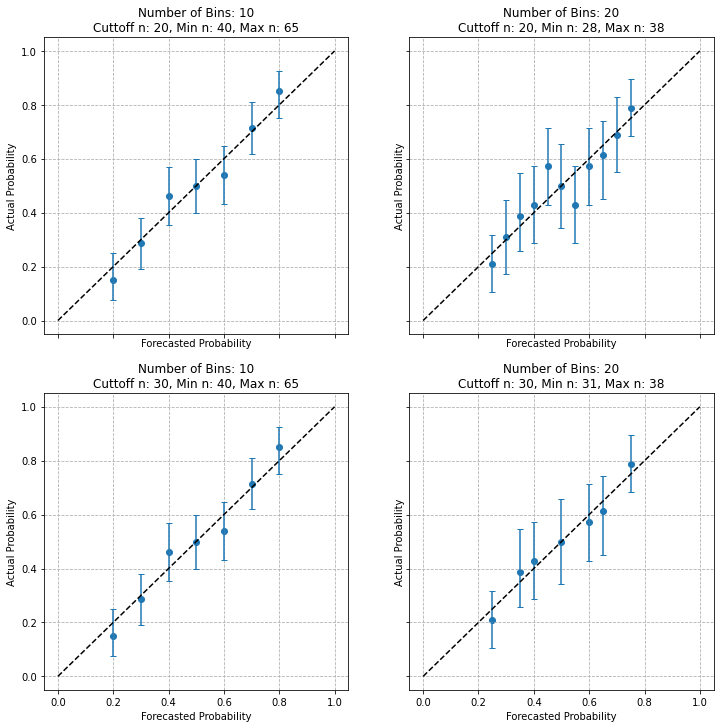

In [6]:
n_mins = [20, 30]
bins = [(0.05, 10), (0.025, 20)]  # (buffer to exclude on the edges, n_bins)
rows = len(n_mins)
cols = len(bins)

for_plts = []

fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(12,12))
for i, x in enumerate(product(n_mins, bins)):
    # compute bins, create symmetrical dfs
    n_min, bns = x[0], x[1]
    step, b = bns[0], bns[1]
    ip = pd.DataFrame(odds['IP_Fav'].append(odds['IP_Dog']).reset_index(drop=True))
    ip['Fav_Winner'] = pd.DataFrame(odds['Fav_Winner'].append(odds['Fav_Winner'].apply(lambda x: flip_ones_w_nan(x))).reset_index(drop=True))
    ip['Bin_'+str(b)] = pd.DataFrame(pd.cut(ip[0], bins=np.linspace(step, 1.0-step, b)).apply(lambda x: x.right-step))  # (left, right]
    ip.set_index('Bin_'+str(b), inplace=True)
    
    # calculate statistics
    for_plt = pd.DataFrame(ip.groupby(by='Bin_'+str(b))['Fav_Winner'].sum() / ip.groupby(by='Bin_'+str(b))['Fav_Winner'].count())
    for_plt['n'] = ip.groupby(by='Bin_'+str(b))['Fav_Winner'].count()
    for_plt = for_plt.loc[for_plt['n'] >= n_min]
    
    # plot
    axs[i//cols][i%cols].set(title='Number of Bins: {}\nCuttoff n: {}, Min n: {}, Max n: {}'.format(b, n_min, for_plt['n'].min(), for_plt['n'].max()), xlabel='Forecasted Probability', ylabel='Actual Probability')
    axs[i//cols][i%cols].scatter(for_plt.index.values, for_plt.iloc[:, 0].values)
    errs = gen_ci_sizes(for_plt[['n', 'Fav_Winner']], alpha=0.1)  # gen CIs
    axs[i//cols][i%cols].errorbar(for_plt.index.values, for_plt.iloc[:, 0].values, errs, fmt='none', capsize=3)
    axs[i//cols][i%cols].plot(np.linspace(0.0, 1, 1000), np.linspace(0.0, 1, 1000), 'k--')
    axs[i//cols][i%cols].grid(b=True, which='major', linestyle='--')
    for_plts.append([n_min, b, for_plt])
plt.show()

# Conclusion

- Between 15 and 85%, the Vegas implied probabilities seem pretty well calibrated and a useful tool for decision making (ie. survivor pool.) 
  - Still, they are not perfect and there's money to be made! 
- As evidenced by the wider CIs, these values could vary +/- 10% or so based on the relatively small sample sizes (max n=65 using 10 bins.)